# Añadir clasificador Random Forest a la CNN
### Modelización de problemas matemáticos UCM 2020 - Magnagement Solutions
#### Equipo: YOLO - You Only Lose Once

Importamos todas las librerías que necesitaremos durante la ejecución:

In [1]:
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys
import warnings 
import os
warnings.filterwarnings('ignore')
import cv2
import time
import keras
import tensorflow as tf
import tensorflow.keras
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


Using TensorFlow backend.


In [2]:
#Este código está porque los algoritmos de convolución los ejecutamos sobre una GPU y sin el código nos da problemas

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 27

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
#tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Comenzaremos cargando en memoria las imágenes, lo cual hacemos mediante la función `load_training_data`:

In [4]:
'''
Función que carga las imágenes en memoria
Argumentos: path - carpeta raíz donde están las carpetas con las distintas fotos de los sentimientos
Return: X - vector con las fotos
        Y - vector con el sentimiento de cada fotografía
'''

def load_training_data(path):
    X = np.empty((0,48,48,1))
    Y = np.empty((0,1))
    X_tmp = np.empty((0,48,48,1))
    init_time = time.time()
    t = time.time()
    
    cont = 0
    num_current_folder = 0
    
    #Cargamos cada carpeta por separado
    for current_folder in os.listdir(path):
        print("Current folder: " + current_folder)

        current_folder_path = os.path.join(path, current_folder)
        
        for image in os.listdir(current_folder_path):
            
            #Cargamos la imagen
            image_path = os.path.join(current_folder_path, image)
            image_vector = cv2.imread(image_path,0)
            image_vector_np = np.array(image_vector)
            
            # Cargamos las imágenes empleando mini-batches. Si concatenamos al array X cada vez que cargamos una imagen, 
            #  estaríamos haciendo demasiadas concatenaciones ineficientes. Para ello usamos un array intermedio, que 
            #  concatenamos a X cada 100 imágenes
            X_tmp = np.append(X_tmp, image_vector_np)
            Y = np.append(Y, num_current_folder)
            cont = cont + 1
            
            if cont == 100:
                X = np.append(X, X_tmp)
                cont = 0
                X_tmp = np.empty((0,48,48,1))
                
        num_current_folder = num_current_folder + 1

        
    X = np.append(X, X_tmp)
    #X /= 255
    X = np.reshape(X, (-1,48,48,1))
           
    print("Time needed: " + str(time.time() - init_time))
        
    return X, Y

Cargamos las fotos tanto de entrenamiento como de test y dividimos el conjunto de entrenamiento en la parte que utilizaremos para entrenar (90%) y la que emplearemos para validar el funcionamiento de nuestro modelo (10%).

<b>Este código está ya preparado para el entrenamiento final</b>, en el que se entrena con los conjuntos de train y validación y se prueba sobre el de test. Para hacer las pruebas con los hiperparámetros, se emplean los datos de train para entrenar y los de validación para comprobar los resultados. Para ello, habría que descomentar las líneas de validación comentadas a lo largo del documento

In [5]:
from sklearn.model_selection import train_test_split
import copy

X_train, Y_train = load_training_data(os.path.join('Data','train'))
X_test, Y_test = load_training_data(os.path.join('Data','test'))

#X_train, X_val, Y_train, Y_val = train_test_split(X_train, 
#                                                  Y_train,
#                                                  test_size = 0.1, 
#                                                  random_state = 27,
#                                                  stratify = Y_train)

#Volteamos las imágenes de train
X_train_2 = np.empty((0,48,48,1));
X_aux = np.empty((0,48,48,1));
Y_train_2 = np.empty((0,1))
cont = 0
gr = 0

for img, sol in zip(X_train, Y_train):
    img.reshape(48,48)
    flipHorizontal = copy.deepcopy(img)
    flipHorizontal = cv2.flip(flipHorizontal, 1)
    flipHorizontal_np = np.array(flipHorizontal)
    
    X_aux = np.append(X_aux, img)
    X_aux = np.append(X_aux, flipHorizontal_np)
    Y_train_2 = np.append(Y_train_2, sol)
    Y_train_2 = np.append(Y_train_2, sol)
    cont = cont + 2
    
    if cont > 100:
        X_train_2 = np.append(X_train_2, X_aux)
        X_aux = np.empty((0,48,48,1));
        cont = 0
        gr = gr + 1
        
X_train_2 = np.append(X_train_2, X_aux)
        
X_train_2 = np.reshape(X_train_2, (-1,48,48,1))
X_train = X_train_2

Y_train = Y_train_2

Current folder: angry
Current folder: disgusted
Current folder: fearful
Current folder: happy
Current folder: neutral
Current folder: sad
Current folder: surprised
Time needed: 116.84297490119934
Current folder: angry
Current folder: disgusted
Current folder: fearful
Current folder: happy
Current folder: neutral
Current folder: sad
Current folder: surprised
Time needed: 4.435153245925903


In [6]:
print("Tamaño del conjunto de entrenamiento: " + str(X_train.shape))
#print("Tamaño del conjunto de validación: " + str(X_val.shape))
print("Tamaño del conjunto de test: " + str(X_test.shape))

Tamaño del conjunto de entrenamiento: (57354, 48, 48, 1)
Tamaño del conjunto de test: (7178, 48, 48, 1)


Nuestra red neuronal espera una codificación one hot, de lo cual se encarga la siguiente función:

In [7]:
'''
Función que codifica un array a one-hot
Argumentos: Y - vector a codificar
            n - número de clases distintas
Return: Y_one_hot - vector de vectores en codificación one hot
'''
def one_hot_encoding(Y, n = 7):
    Y_one_hot = np.empty((0, n))
    
    for i in range(0, len(Y)):
        np_oh = np.zeros(n)
        np_oh[int(Y[i])] = 1
        Y_one_hot = np.append(Y_one_hot, np_oh)
        
        
    Y_one_hot = np.reshape(Y_one_hot, (-1, 7))
    return Y_one_hot        

In [8]:
Y_test_oh = one_hot_encoding(Y_test)
#Y_val_oh = one_hot_encoding(Y_val)
Y_train_oh = one_hot_encoding(Y_train)

print("Tamaño del conjunto de entrenamiento: " + str(Y_train_oh.shape))
#print("Tamaño del conjunto de validación: " + str(Y_val_oh.shape))
print("Tamaño del conjunto de test: " + str(Y_test_oh.shape))

Tamaño del conjunto de entrenamiento: (57354, 7)
Tamaño del conjunto de test: (7178, 7)


In [9]:
#CARGAR EL MODELO
modelN = tensorflow.keras.models.load_model('62_26')

Comenzamos analizando cuales son los resultados de la red convolucional, viendo en cuántas fotos acierta el sentimiento en el conjunto de test.

In [10]:
#score = modelN.evaluate(X_val, Y_val_oh, verbose=0)
#print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

In [11]:
score = modelN.evaluate(X_test, Y_test_oh, verbose=0)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

model accuracy: 62.26%


Ahora, vamos a sustituir el clasificador que empleamos al final, probando con varios distintos. Para ello, dividimos la red neuronal en dos partes: la que se encarga de extraer las "features" de la imagen y la que se encarga de transformar esas features en una clase.

In [12]:
from keras import backend as K
for l in range(len(modelN.layers)):
    print(l, modelN.layers[l])

0 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020A33152898>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020A3318BDA0>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020A341C8EF0>
3 <tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x0000020A3C16D630>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020A3C16DE48>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020A3C187FD0>
6 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020A3C1A7208>
7 <tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x0000020A3C1C18D0>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020A3C1D7550>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020A3C1C1DD8>
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020A0A724208>
11 <tensorflow.python.keras.layers.pooling.AveragePoolin

In [13]:
getFeature = K.function([modelN.layers[0].input, K.learning_phase()],
                        [modelN.layers[13].output])

Esta función se encargará de a partir de un vector de imágenes, devolvernos para cada imagen su vectorización con las features extraídas por la CNN.

In [14]:
'''
Función que vectoriza las imágenes
Argumentos: X - vector con las imágenes
Return: exTrain - vector con la vectorización de cada imagen
'''
def extract_features(X):
    init_time = time.time()
    exTrain = np.empty((0,64))
    X_aux = np.empty((0,64))

    for i in range(0, len(X)):
        act = getFeature([X[i].reshape(1,48,48,1), 0])[0]
      
        X_aux = np.concatenate((X_aux, act), axis = 0)

        if(i % 100 == 0):
            exTrain = np.concatenate((exTrain, X_aux), axis = 0)
            X_aux = np.empty((0,64))
        if(i % 1000 == 0):
            print("It " + str(i))
            #print(exTrain.shape)
    exTrain = np.concatenate((exTrain, X_aux), axis = 0) 
    
    print(exTrain.shape)
    return exTrain

In [15]:
#Vectores con las features de cada conjunto
import time

init_time = time.time()
X_train_features = extract_features(X_train)
#X_val_features = extract_features(X_val)
X_test_features = extract_features(X_test)

print("Tiempo empleado: " + str(time.time() - init_time))

It 0
It 1000
It 2000
It 3000
It 4000
It 5000
It 6000
It 7000
It 8000
It 9000
It 10000
It 11000
It 12000
It 13000
It 14000
It 15000
It 16000
It 17000
It 18000
It 19000
It 20000
It 21000
It 22000
It 23000
It 24000
It 25000
It 26000
It 27000
It 28000
It 29000
It 30000
It 31000
It 32000
It 33000
It 34000
It 35000
It 36000
It 37000
It 38000
It 39000
It 40000
It 41000
It 42000
It 43000
It 44000
It 45000
It 46000
It 47000
It 48000
It 49000
It 50000
It 51000
It 52000
It 53000
It 54000
It 55000
It 56000
It 57000
(57354, 64)
It 0
It 1000
It 2000
It 3000
It 4000
It 5000
It 6000
It 7000
(7178, 64)
Tiempo empleado: 62.00932240486145


In [16]:
y_train_sv = Y_train.reshape(Y_train.shape[0],)
#y_val_sv = Y_val.reshape(Y_val.shape[0],)
y_test_sv = Y_test.reshape(Y_test.shape[0],)

## Ajustamos el Random Forest

In [17]:
'''
from sklearn.ensemble import RandomForestClassifier
import time

init = time.time()
rclf = RandomForestClassifier(max_depth = None, max_features = 'auto', min_samples_split = 5, min_samples_leaf = 3, bootstrap = False, criterion = "gini", n_estimators = 1000, n_jobs=-1)             
print(rclf.fit(X_train_features, y_train_sv))
print(time.time() - init)
'''

'\nfrom sklearn.ensemble import RandomForestClassifier\nimport time\n\ninit = time.time()\nrclf = RandomForestClassifier(max_depth = None, max_features = \'auto\', min_samples_split = 5, min_samples_leaf = 3, bootstrap = False, criterion = "gini", n_estimators = 1000, n_jobs=-1)             \nprint(rclf.fit(X_train_features, y_train_sv))\nprint(time.time() - init)\n'

In [18]:
#Guardamos el modelo
'''
import pickle

filename = 'RF 62,26 Primera densa'
pickle.dump(rclf, open(filename, 'wb'))
'''

"\nimport pickle\n\nfilename = 'RF 62,26 Primera densa'\npickle.dump(rclf, open(filename, 'wb'))\n"

## Examinamos los resultados obtenidos
En caso de querer examinar directamente los resulados obtenidos, tendremos que ejecutar todo el notebook excepto las dos celdas anteriores (las de la sección "Ajustamos el Random Forest"). Por ello, tenemos que cargar el clasificador desde un archivo previamente guardado. Os hemos dejado preparado ya el nombre del archivo y el notebook con las celdas anteriores comentadas para que solo tengáis que ejecutarlo y obtengáis los resultados.

In [19]:
#Cargamos el modelo
import pickle

filename = 'RF 62,26 Primera densa'
rclf = pickle.load(open(filename, 'rb'))

In [20]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def print_cmx(y_true, y_pred, cmap=plt.cm.Blues):
    """
    The function is used to construct the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    mpl.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    labels = ['angry', 'disgust','fear', 'happy', 'neutral','sad', 'surprise']
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      7972
         1.0       0.99      0.84      0.91       870
         2.0       0.95      0.93      0.94      8188
         3.0       0.97      0.98      0.97     14418
         4.0       0.94      0.95      0.94      9918
         5.0       0.93      0.96      0.94      9658
         6.0       0.97      0.95      0.96      6330

    accuracy                           0.95     57354
   macro avg       0.96      0.94      0.95     57354
weighted avg       0.95      0.95      0.95     57354

Accuracy: 0.9533772709837152


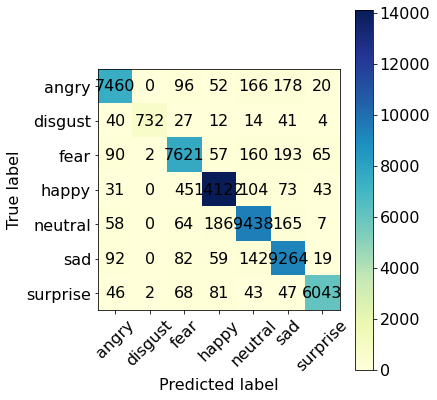

In [21]:
y_trainSVM = rclf.predict(X_train_features)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_train_sv, y_trainSVM, cmap=plt.cm.YlGnBu)
print(classification_report(y_train_sv, y_trainSVM))
print("Accuracy: {0}".format(accuracy_score(y_train_sv, y_trainSVM)))

In [22]:
'''
y_valSVM = rclf.predict(X_val_features)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_val_sv, y_valSVM, cmap=plt.cm.YlGnBu)
print(classification_report(y_val_sv, y_valSVM))
print("Accuracy: {0}".format(accuracy_score(y_val_sv, y_valSVM)))
'''

'\ny_valSVM = rclf.predict(X_val_features)\n\nfrom sklearn.metrics import confusion_matrix, classification_report, accuracy_score\n\nprint_cmx(y_val_sv, y_valSVM, cmap=plt.cm.YlGnBu)\nprint(classification_report(y_val_sv, y_valSVM))\nprint("Accuracy: {0}".format(accuracy_score(y_val_sv, y_valSVM)))\n'

Número de fotografías: 7178
Tiempo total: 1.3968021869659424
Tiempo por fotografía: 0.0001945948992708195
              precision    recall  f1-score   support

         0.0       0.55      0.55      0.55       958
         1.0       0.72      0.40      0.51       111
         2.0       0.47      0.44      0.45      1024
         3.0       0.84      0.84      0.84      1774
         4.0       0.58      0.62      0.60      1233
         5.0       0.48      0.50      0.49      1247
         6.0       0.80      0.77      0.78       831

    accuracy                           0.63      7178
   macro avg       0.63      0.59      0.60      7178
weighted avg       0.63      0.63      0.63      7178

Accuracy: 0.6309556979660073


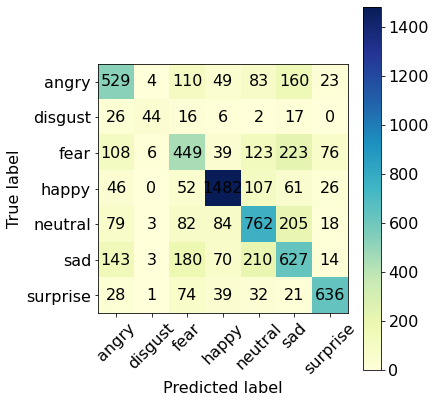

In [23]:
init_time = time.time()
y_testSVM = rclf.predict(X_test_features)
fin_time = time.time()

print("Número de fotografías: " + str(len(X_test_features)))
print("Tiempo total: " + str(fin_time - init_time))
print("Tiempo por fotografía: " + str((fin_time - init_time)/len(X_test_features)))

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_test_sv, y_testSVM, cmap=plt.cm.YlGnBu)
print(classification_report(y_test_sv, y_testSVM))
print("Accuracy: {0}".format(accuracy_score(y_test_sv, y_testSVM)))

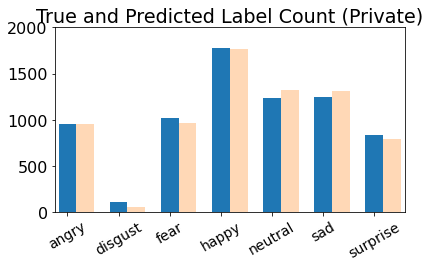

In [24]:
int_y_test_pred = [int(res) for res in y_testSVM]
int_y_test_true = [int(res) for res in y_test_sv]
#for i in range(0,len(y_testSVM)):
#    y_testSVM[i] = int(y_testSVM[i])

def plot_distribution2(y_true, y_pred):
    """
    The function is used to compare the number of true labels as well as prediction results
    """
    #colorset = Dark2_7.get_mpl_colormap() #brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    ind = np.arange(1.5,8,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, alpha=0.3)
    ax.set_xticks(np.arange(1.5,8,1))
    labels = ['angry', 'disgust','fear', 'happy', 'neutral','sad', 'surprise']
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 8.1])
    ax.set_ylim([0, 2000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()
    
#print(y_test_sv.shape)
#print(y_testSVM.shape)
plot_distribution2(int_y_test_true, int_y_test_pred)